In [1]:
import numpy as np 
import pandas as pd 
import dask.dataframe as ddf
import tensorflow as tf
import os
from os import environ
!mamba run -n tf_on_gpu pip install -q pyarrow

print (tf.test.gpu_device_name())


/device:GPU:0


2022-12-20 07:46:09.314678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 07:46:09.477240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:46:09.490506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:46:09.492538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

In [2]:
from feather_io import FeatherReader    

train_dataset = FeatherReader(environ.get("TRAIN_DATA", "resolution-train")).as_tf_dataset()
validation_dataset = FeatherReader(environ.get("VALIDATION_DATA", "resolution-validation")).as_tf_dataset()

2022-12-20 07:46:10.346933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:46:10.348262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:46:10.349494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:46:10.351381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:46:10.352618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [3]:
X, y = next(iter(train_dataset.batch(1_000_000)))
y.shape

2022-12-20 07:46:10.699732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


TensorShape([352818, 9])

In [4]:
g_input = tf.keras.layers.Input(shape=[X.shape[1]])
random = tf.keras.layers.Input(shape=[128])

g_dense_cfg=dict(units=128, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-3))

x = tf.keras.layers.Concatenate(axis=1)((g_input, random))
x = tf.keras.layers.Dense(**g_dense_cfg)(x)
for i in range(10):
    x_ = tf.keras.layers.Dense(**g_dense_cfg)(x)
    x = x + x_

ny = y.shape[1]
output = tf.keras.layers.Dense(ny)(x) #+ random[:, :ny]
    
    
generator = tf.keras.Model(inputs=[g_input, random], outputs = output)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 140)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          18048       concatenate[0][0]            

In [5]:
d_input_ref_x = tf.keras.layers.Input(shape=[X.shape[1]])

d_input_ref_y = tf.keras.layers.Input(shape=[y.shape[1]])
d_input_gen_y = tf.keras.layers.Input(shape=[y.shape[1]])

d_input_y = tf.keras.layers.Concatenate(axis=0)((d_input_ref_y, d_input_gen_y))
d_input_x = tf.keras.layers.Concatenate(axis=0)((d_input_ref_x, d_input_ref_x))

d_input = tf.keras.layers.Concatenate(axis=1)((d_input_x, d_input_y))

d_dense_cfg=dict(units=128, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-3))

x = tf.keras.layers.Dense(**d_dense_cfg)(d_input)
for i in range(10):
    x_ = tf.keras.layers.Dense(**d_dense_cfg)(x)
    x = x + x_

output = tf.keras.layers.Dense(1)(x)

discriminator = tf.keras.Model(inputs=[d_input_ref_x, d_input_ref_y, d_input_gen_y], outputs=[output])
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 12)           0           input_3[0][0]                    
                                                                 input_3[0][0]              

In [6]:
r_input_ref_x = tf.keras.layers.Input(shape=[X.shape[1]])

r_input_ref_y = tf.keras.layers.Input(shape=[y.shape[1]])
r_input_gen_y = tf.keras.layers.Input(shape=[y.shape[1]])

r_input_y = tf.keras.layers.Concatenate(axis=0)((r_input_ref_y, r_input_gen_y))
r_input_x = tf.keras.layers.Concatenate(axis=0)((r_input_ref_x, r_input_ref_x))

r_input = tf.keras.layers.Concatenate(axis=1)((r_input_x, r_input_y))

r_dense_cfg=d_dense_cfg

x = tf.keras.layers.Dense(**r_dense_cfg)(r_input)
for i in range(10):
    x_ = tf.keras.layers.Dense(**r_dense_cfg)(x)
    x = x + x_

output = tf.keras.layers.Dense(1)(x)

referee = tf.keras.Model(inputs=[r_input_ref_x, r_input_ref_y, r_input_gen_y], outputs=[output])
referee.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 12)           0           input_6[0][0]                    
                                                                 input_6[0][0]              

In [7]:
compute_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)
r_optimizer = tf.keras.optimizers.Adam(5e-4)

@tf.function
def train_step(dataset):
    X, y_ref = dataset
    batch_size = tf.shape(X)[0]
    label_true = tf.concat((tf.ones(batch_size), tf.zeros(batch_size)), axis=0)

    r = tf.random.normal([batch_size, random.shape[1]], 0., 1.)
    
    with tf.GradientTape(watch_accessed_variables=False) as tape_generator:
        with tf.GradientTape(watch_accessed_variables=False) as tape_discriminator:
            tape_generator.watch(generator.weights)
            tape_discriminator.watch(discriminator.weights)
            
            y_gen = generator((X, r))

            label_pred = discriminator((X, y_ref, y_gen))

            d_loss = compute_loss(label_true, label_pred)
            g_loss = -d_loss
            
    with tf.GradientTape() as tape_referee:
        tape_referee.watch(referee.weights)
        label_referee = referee((X, y_ref, y_gen))
        r_loss = compute_loss(label_true, label_referee)

    
    g_vars = generator.weights
    d_vars = discriminator.weights
    r_vars = referee.weights
    
    d_grads = tape_discriminator.gradient(d_loss, d_vars)
    g_grads = tape_generator.gradient(g_loss, g_vars)
    r_grads = tape_referee.gradient(r_loss, r_vars)
 
    #print (g_grads)
    
    g_optimizer.apply_gradients(zip(g_grads, g_vars))
    d_optimizer.apply_gradients(zip(d_grads, d_vars))
    r_optimizer.apply_gradients(zip(r_grads, r_vars))
    
    return r_loss

    

@tf.function
def test_step(dataset):
    X, y_ref = dataset
    batch_size = tf.shape(X)[0]
    r = tf.random.normal([batch_size, random.shape[1]], 0., 1.)
    
    y_gen = generator((X, r))

    label_pred = referee((X, y_ref, y_gen))
    label_true = tf.concat((tf.ones(batch_size), tf.zeros(batch_size)), axis=0)

    return compute_loss(label_true, label_pred)
    

In [8]:
from tqdm import trange, tqdm

losses = []
validation_loss = []

vdst = next(iter(validation_dataset.batch(100_000)))

progress_bar = trange(1000)

for epoch in progress_bar:
    epoch_losses = []
    for dset in train_dataset.batch(1000):
        epoch_losses.append(train_step(dset))
    losses.append(np.mean(epoch_losses))
    validation_loss.append(test_step(vdst))
    
    progress_bar.set_description(f"Training (validation) loss: {losses[-1]:.3f} ({validation_loss[-1]:.3f})")

Training (validation) loss: 0.651 (0.651): 100%|██████████| 500/500 [17:03<00:00,  2.05s/it]


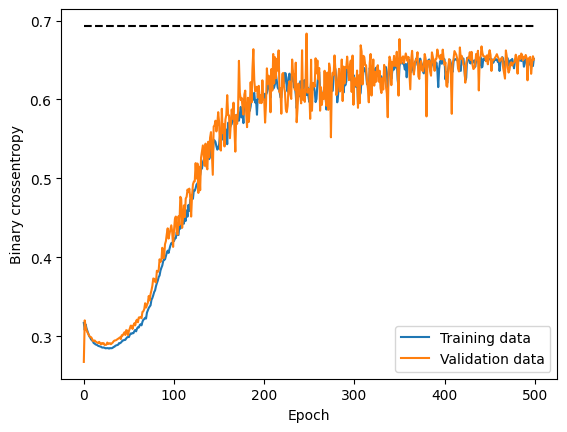

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses, label="Training data")
plt.plot(validation_loss, label="Validation data")
plt.plot([0, len(losses)], [np.log(2)]*2, 'k--')

plt.xlabel("Epoch")


plt.ylabel("Binary crossentropy")
plt.legend()
plt.show()

In [10]:
import os
default_output_model = "/workarea/cloud-storage/anderlinil/models/resolution"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
generator.save(output_model)

2022-12-20 08:03:16.889861: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workarea/cloud-storage/anderlinil/models/resolution/assets
